In [1]:
from os import listdir
from os.path import isfile, join
import re
from email import parser as ep
import pandas as pd
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix

parser = ep.Parser()

Using TensorFlow backend.


In [14]:
# Path to annotated mails
mailpathAnno = '/home/tim/Uni/HPI/workspace/enron_data/splitting/annotated/'
# Path to all the other mails
mailpathMore = '/home/tim/Uni/HPI/workspace/enron_data/splitting/data/'

# % of mails used for training
splitratio = 0.3

# window size
linesAtOnce = 8

annotationMap = {'H':0, 'B':1, 'S':1}
annotationMapInv = {0:'H', 1:'B'}

# annotation to number (use this to include signature detection)
#annotationMap = {'H':0, 'B':1, 'S':2}
#annotationMapInv = {0:'H', 1:'B', 2:'S'}


cols = ['5special:0', 
        'alphnum<10:0', 
        'alphnum<50:0', 
        'alphnum<90:0', 
        #'anno',
        'blank_line:0', 
        'containsHeaderStart:0', 
        'containsMimeWord:0',
        'containsSenderName_any:0', 
        'containsSenderName_first:0',
        'containsSenderName_last:0', 
        'containsSenderName_mail:0',
        'containsSignatureWord:0',
        'emailpattern:0', 
        #'hasWord=bcc:0', 
        #'hasWord=cc:0', 
        #'hasWord=cell:0',
        #'hasWord=date:0', 
        #'hasWord=fax:0', 
        #'hasWord=from:0', 
        #'hasWord=fwdby:0',
        #'hasWord=fwdmsg:0', 
        #'hasWord=origmsg:0', 
        #'hasWord=phone:0',
        #'hasWord=sent:0', 
        #'hasWord=subj:0', 
        #'hasWord=subject:0', 
        #'hasWord=to:0',
        'lastline:0', 
        #'line', 
        #'mail', 
        'namePattern:0', 
        'nextSamePunct:0',
        'numTabs=1:0', 
        'numTabs=2:0', 
        'numTabs>=3:0', 
        'prevSamePunct:0',
        'prevToLastLine:0', 
        'punctuation>20:0', 
        'punctuation>50:0',
        'punctuation>90:0', 
        'quoteEnd:0', 
        'signatureMarker:0',
        'startWithPunct:0', 
        #'text', 
        'typicalMarker:0',
        #'beginswithShape=Xx{2,8}\::0',
        #'hasForm=^dd/dd/dddd dd:dd ww$:0',
        #'containsForm=dd/dd/dddd dd:dd ww:0',
        #'hasLDAPthings:0',
        #'hasForm=^dd:dd:dd ww$:0'
       ]


def cleanbody(s):
    # remove annotation
    s = re.sub("^(H|S|B)>","",s, flags=re.M)
    
    # remove known common rubbish
    s = s.replace('=\n','').replace('=20','').replace('=09','').replace('=01\&','') \
         .replace('=01&','').replace('=18','').replace('=018','')
    
    # remove indentation
    #s = re.sub(r"^(\s*>)+","", s) 
    
    # remove attachments
    s = re.sub(r"\s*\[IMAGE\]\s*", "", s, flags=re.I)
    s = re.sub(r"<<.{3,50}\.(xls|xlsx|png|gif|jpg|jpeg|doc|docx|ppt|pptx|pst)>>%?", "", s, flags=re.I)
    s = re.sub(r"^\s*-.{3,50}\.(xls|xlsx|png|gif|jpg|jpeg|doc|docx|ppt|pptx|pst)%?", "", s, flags=re.I)
    return s


def readDir(mailpath, num=None):
    mails = []
    bodies = []
    annos = []
    for i, f in enumerate(listdir(mailpath)):
        if num and i>=num:
            break
            
        if isfile(join(mailpath, f)):
            with open(join(mailpath, f)) as file:
                mail = parser.parsestr(file.read())
                mails.append(mail)
                annos.append([l[0] if len(l)>0 else 'b' for l in iter(mail.get_payload().splitlines())])
                bodies.append(cleanbody(mail.get_payload()))
                
    return (mails, bodies, annos)  


def fromp(xfrom):
    fn = ln = mail = None
    
    match = re.search(r"(?P<ln>\w+), (?P<fn>\w+)(?: ?(?P<mn>\w)\.?)?", xfrom)
    if match:
        fn = match.group('fn')
        ln = match.group('ln')
    else:
        match = re.search(r"(?P<fn>\w+) (?:(?P<mn>\w)\.? )?(?P<ln>\w+)", xfrom)
        if match:
            fn = match.group('fn')
            ln = match.group('ln')
        else:
            fn = re.sub(r"\W","",xfrom.split(' ')[0],flags=re.I)
    
    match = re.search(r"(?P<mail>[a-z0-9\.\-_]+@[a-z0-9\.\-_]+\.[a-z]{2,3})", xfrom, flags=re.I)
    if match:
        mail = match.group('mail')
    
    return (fn,ln,mail)
    
    
def features(body, li, mail):
    sb = body.splitlines()
    line = sb[li]
    cline = re.sub(r"^\s*(H|B|S)>(\s*>?)+", "", line)
    
    punctuation = r"(\!|\"|\#|\$|\%|\&|\\|\'|\(|\)|\*|\+|\,|\-|\.|\/|\:|\;|\<|\=|\>|\?|\@|\[|\]|\^|\_|\`|\{|\||\}|\~|\')"
    fn,ln,ml = fromp(mail['X-From'])
    
    feats = {
        'blank_line:0': len(line.strip())==0,
        'emailpattern:0': bool(re.search(r"[a-z0-9\.\-_]+@[a-z0-9\.\-_]+\.[a-z]{2,3}", line, flags=re.I)),
        'lastline:0': (len(sb)-1)==li,
        'prevToLastLine:0': (len(sb)-2)==li,
        # email header pattern
        # url pattern
        # phone number pattern
        'signatureMarker:0': bool(re.match(r"^\s*\-\-\-*\s*$", line)),
        '5special:0': bool(re.search(r"^\s*(\*|#|\+|\^|\-|\~|_|\&|\/|\$|\!|\%|\:|\=){5,}", line)),
        # typical signature words (dept, university, corp,...)
        'namePattern:0': bool(re.search(r"[A-Z][a-z]+\s\s?[A-Z]\.?\s\s?[A-Z][a-z]+", line)),
        'quoteEnd:0': bool(re.search(r"\"$", line)),
        'containsSenderName_first:0': bool(fn) and fn.lower() in line.lower(),
        'containsSenderName_last:0': bool(ln) and ln.lower() in line.lower(),
        'containsSenderName_mail:0': bool(ml) and ml.lower() in line.lower(),
        'numTabs=1:0': line.count('\t') == 1,
        'numTabs=2:0': line.count('\t') == 2,
        'numTabs>=3:0': line.count('\t') >= 3,
        'punctuation>20:0': len(line)>0 and (len(re.findall(punctuation,line))/len(line))>0.2,
        'punctuation>50:0': len(line)>0 and (len(re.findall(punctuation,line))/len(line))>0.5,
        'punctuation>90:0': len(line)>0 and (len(re.findall(punctuation,line))/len(line))>0.9,
        'typicalMarker:0': bool(re.search(r"^\>", line)),
        'startWithPunct:0': bool(re.search(r"^"+punctuation, line)),
        'nextSamePunct:0': True if (li+1 >=len(sb) or 0==len(line)==len(sb[li+1])) else (bool(re.search(r"^"+punctuation, sb[li+1])) and len(line)>0 and len(sb[li+1])>0 and sb[li+1][0]==line[0]),
        'prevSamePunct:0': True if (li-1 >=0 or 0==len(line)==len(sb[li-1])) else (bool(re.search(r"^"+punctuation, sb[li-1])) and len(line)>0 and len(sb[li-1])>0 and sb[li-1][0]==line[0]),
        # starts with 1-2 punct followed by reply marker: "^\p{Punct}{1,2}\>"
        # reply line clue: "wrote:$" or "writes:$"
        'alphnum<90:0': len(line)>0 and (len(re.findall('[a-zA-Z0-9]', line))/len(line))<0.9,
        'alphnum<50:0': len(line)>0 and (len(re.findall('[a-zA-Z0-9]', line))/len(line))<0.5,
        'alphnum<10:0': len(line)>0 and (len(re.findall('[a-zA-Z0-9]', line))/len(line))<0.1,
        'hasWord=fwdby:0': bool(re.search(r"forwarded by",line, flags=re.I)),
        'hasWord=origmsg:0': bool(re.search(r"original message",line, flags=re.I)),
        'hasWord=fwdmsg:0': bool(re.search(r"forwarded message",line, flags=re.I)),
        'hasWord=from:0': bool(re.search(r"from:",cline, flags=re.I)),
        'hasWord=to:0': bool(re.search(r"to:",cline, flags=re.I)),
        'hasWord=subject:0': bool(re.search(r"subject:",cline, flags=re.I)),
        'hasWord=cc:0': bool(re.search(r"cc:",cline, flags=re.I)),
        'hasWord=bcc:0': bool(re.search(r"bcc:",cline, flags=re.I)),
        'hasWord=subj:0': bool(re.search(r"subj:",cline, flags=re.I)),
        'hasWord=date:0': bool(re.search(r"date:",cline, flags=re.I)),
        'hasWord=sent:0': bool(re.search(r"sent:",cline, flags=re.I)),
        'hasWord=sentby:0': bool(re.search(r"sent by:",cline, flags=re.I)),
        'hasWord=fax:0': bool(re.search(r"fax",cline, flags=re.I)),
        'hasWord=phone:0': bool(re.search(r"phone",cline, flags=re.I)),
        'hasWord=cell:0': bool(re.search(r"phone",cline, flags=re.I)),
        'beginswithShape=Xx{2,8}\::0': bool(re.search(r"[A-Z][a-z]{1,7}:",cline)),
        'hasForm=^dd/dd/dddd dd:dd ww$:0': bool(re.search(r"^\s*\d\d\/\d\d\/\d\d\d\d \d?\d\:\d\d(\:\d\d)? ?(am|pm)?\s*$", cline, flags=re.I)),
        'hasForm=^dd:dd:dd ww$:0': bool(re.search(r"^\s*\d\d\:\d\d(\:\d\d)? ?(am|pm)\s*$", cline, flags=re.I)),
        'containsForm=dd/dd/dddd dd:dd ww:0': bool(re.search(r"on\s*\d\d\/\d\d\/\d\d\d\d \d?\d\:\d\d(\:\d\d)? ?(am|pm)?", cline, flags=re.I)),
        'hasLDAPthings': bool(re.search(r"\w+ \w+\/[A-Z]{1,4}\/[A-Z]{2,8}@[A-Z]{2,8}", cline))
        
    }
    feats['containsSenderName_any:0'] = feats['containsSenderName_first:0'] or \
                                        feats['containsSenderName_last:0'] or \
                                        feats['containsSenderName_mail:0']
    
    feats['containsMimeWord:0'] = feats['hasWord=from:0'] or feats['hasWord=to:0'] or feats['hasWord=cc:0'] or \
                                  feats['hasWord=bcc:0'] or feats['hasWord=subject:0'] or feats['hasWord=subj:0'] or \
                                  feats['hasWord=date:0'] or feats['hasWord=sent:0'] or feats['hasWord=sentby:0']
    
    feats['containsHeaderStart:0'] = feats['hasWord=fwdby:0'] or feats['hasWord=origmsg:0'] or \
                                     feats['hasWord=fwdmsg:0']
    
    feats['containsSignatureWord:0'] = feats['hasWord=fax:0'] or feats['hasWord=cell:0'] or feats['hasWord=phone:0']
    
    return feats


def toFrame(bodies, mails, annos):
    x = []
    for i in range(len(mails)):
        spl = bodies[i].splitlines()
        for j in range(len(spl)):
            f = features(bodies[i], j, mails[i])
            f['mail'] = i
            f['line'] = j
            f['text'] = spl[j]
            f['anno'] = annos[i][j]
            x.append(f)
    return pd.DataFrame(x)


# amap (annotation to number): H: Header, B: Body, S: Signature
# windowsize: set to None to get nested documents
# caty: set true to get sparse vectors y (1 -> [010])
def toNested(frm, windowsize=None, caty=False, amap={'H':0, 'B': 1, 'S':2}):
    retx = []
    rety = []
    reti = []
    d = {True: 1, False: -1}
    for m, lines in frm.groupby('mail'):
        ws = (windowsize if windowsize else len(lines)-1)
        for wi in range(len(lines)-ws+1):
            # make frame of windowsize
            window = lines[wi:(wi+ws)]
            
            # get X
            retx.append(window.applymap(lambda x: d.get(x,x)).as_matrix(columns=cols))
            
            # get Y
            tmpy = list(window['anno'].apply(lambda x: amap.get(x.upper(),0)))
            rety.append(tmpy if not caty else np_utils.to_categorical(tmpy, nb_classes=len(set(amap.values()))))
            
            reti.append(list(window.index))
    return (np.array(retx), np.array(rety), reti)


def draw_traingraph(hist):
    plt.subplot(121)
    plt.plot(hist['acc'], label='accuracy')
    if 'val_acc' in hist:
        plt.plot(hist['val_acc'], label='eval_accuracy')
    plt.legend(loc='lower right')
    
    plt.subplot(122)
    plt.plot(hist['loss'], label='loss')
    if 'val_loss' in hist:
        plt.plot(hist['val_loss'], label='eval_loss')
    plt.legend(loc='upper right')


def evaluate(Y_test, y_pred, Y_test_flat, y_pred_flat):
    corr = 0
    cnt = 0
    corrdeep = 0
    cntdeep = 0

    t = [[np.argmax(k) for k in u] for u in Y_test]
    p = [[np.argmax(k) for k in u] for u in y_pred]
    for i, a in enumerate(t):
        tmp = True
        for j, b in enumerate(a):
            tmp = tmp and (t[i][j]==p[i][j])
            corrdeep += 1 if (t[i][j]==p[i][j]) else 0
            cntdeep += 1
        if tmp:
            corr += 1
        cnt += 1
        
    print('correct windows:',corr,"/",cnt,"=",(corr/cnt))
    print('correct lines', corrdeep,"/",cntdeep,"=",(corrdeep/cntdeep))
    print("================================")

    print("==== each line in all the windows ====")
    print(classification_report([np.nanargmax(k) for u in Y_test for k in u], 
                                [np.nanargmax(k) for u in y_pred for k in u],
                                target_names=['(H)eader','(B)ody','(S)ignature']))
    print(confusion_matrix([np.nanargmax(k) for u in Y_test for k in u], 
                           [np.nanargmax(k) for u in y_pred for k in u]))

    print("\n==== each line based on merged predictions ====")
    print(classification_report(Y_test_flat, y_pred_flat,
                                target_names=['(H)eader','(B)ody','(S)ignature']))
    print(confusion_matrix(Y_test_flat, y_pred_flat))

    
def flattenP(I_test, y_pred,frm, verbose=True, check=True):
    y_pred_flat = []
    Y_pred_flat = []
    Y_test_flat = []
    I_test_flat = []

    preds = {}
    for i, window in enumerate(I_test):
        for j, maili in enumerate(window):
            if maili not in preds:
                preds[maili] = []
            preds[maili].append(y_pred[i][j])

    for m, lines in frm.groupby('mail'):
        for n, line in lines.iterrows():
            if check:
                try:
                    tmp = np.nanmean(preds[n],axis=0)
                    tmpa = np.nanargmax(tmp)
                    tmpb = annotationMap[line['anno'].upper()]
                    y_pred_flat.append(tmpa)
                    Y_pred_flat.append(tmp)
                    Y_test_flat.append(tmpb)
                    I_test_flat.append(n)
                    if verbose:
                        print(("  " if tmpa==tmpb else "X>")+"("+(", ".join(["%.3f"%p for p in tmp]))+") "+ \
                                annotationMapInv[tmpa] + "|"+line['anno'].upper()+">"+line['text'])
                except KeyError:
                    if verbose:
                        print("  (X.XXX, X.XXX) X|"+line['anno'].upper()+">"+line['text'])
            else:
                try:
                    tmp = np.nanmean(preds[n],axis=0)
                    tmpa = np.nanargmax(tmp)
                    y_pred_flat.append(tmpa)
                    Y_pred_flat.append(tmp)
                    if verbose:
                        print(" ("+(", ".join(["%.3f"%p for p in tmp]))+") "+ \
                                     annotationMapInv[tmpa] + ">"+line['text'])
                except KeyError:
                    if verbose:
                        print(" (X.XXX, X.XXX) X>"+line['text'])
                    
        if verbose:
            print("================================")
            
    return (y_pred_flat, Y_pred_flat, Y_test_flat, I_test_flat)

### Read annotated mails
This also does mail -> lines/header, lines -> feature vectors, vectors -> nested windows

In [3]:
mails, bodies, annos = readDir(mailpathAnno)

X = toFrame(bodies, mails, annos)

testselection = np.random.choice(np.array(list(set(X['mail']))), size=int(len(bodies) * splitratio), replace=False)
test = X[X['mail'].isin(list(testselection))]
train = X[~X['mail'].isin(list(testselection))]

X_train, Y_train, I_train = toNested(train, windowsize=linesAtOnce, caty=True, amap=annotationMap)
X_test, Y_test, I_test = toNested(test, windowsize=linesAtOnce, caty=True, amap=annotationMap)

### Train RNN

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
import keras.optimizers as opts
from keras.regularizers import l2, activity_l2

def shuffle_weights(model, weights=None):
    if weights is None:
        weights = model.get_weights()
    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    model.set_weights(weights)

try:
    bla = blu
    shuffle_weights(model, initial_weights)
except(NameError):
    #del model
    model = None
    model = Sequential()
    model.add(LSTM(X_train.shape[2], 
                   batch_input_shape=(None, linesAtOnce, X_train.shape[2]), 
                   return_sequences=True,
                   init='he_uniform', 
                   inner_init='orthogonal',
                   W_regularizer=l2(0.01), 
                   U_regularizer=l2(0.01),
                   name='rnn_layer1'))
    model.add(Activation('softsign'))
    model.add(Dropout(0.2))
    model.add(LSTM(50,
                   return_sequences=True,
                   init='he_uniform', 
                   inner_init='orthogonal',
                   W_regularizer=l2(0.01), 
                   U_regularizer=l2(0.01),
                   name='rnn_layer2'))
    model.add(Activation('softsign'))
    model.add(Dropout(0.4))
    
    model.add(Dense(Y_train.shape[2], 
                    init='he_uniform',
                    activation='softmax',
                    name='output'))
    model.summary()
    
    model.compile(loss='categorical_crossentropy', # 'msle',
              optimizer='RMSprop', # opts.Adadelta(),
              metrics=['accuracy'])
    
    initial_weights = model.get_weights()

hist = model.fit(X_train, Y_train, batch_size=linesAtOnce, nb_epoch=10, verbose=0, 
          validation_data=(X_test, Y_test)).history

score = model.evaluate(X_test, Y_test, batch_size=linesAtOnce, verbose = 0)
print('score:',score)
print('hist:', hist)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
rnn_layer1 (LSTM)                (None, 8, 28)         6384        lstm_input_1[0][0]               
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 8, 28)         0           rnn_layer1[0][0]                 
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 8, 28)         0           activation_1[0][0]               
____________________________________________________________________________________________________
rnn_layer2 (LSTM)                (None, 8, 50)         15800       dropout_1[0][0]                  
___________________________________________________________________________________________

use this to continue training for additional epochs

In [38]:
oldhist = hist
hist = model.fit(X_train, Y_train, batch_size=linesAtOnce, nb_epoch=5, verbose=0, 
          validation_data=(X_test, Y_test)).history
hist = {k: v + hist[k] for k,v in oldhist.items()}

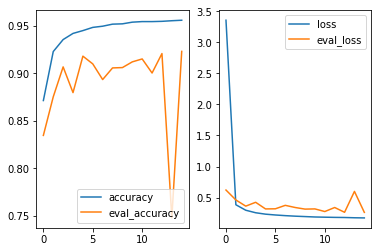

In [39]:
%matplotlib inline
draw_traingraph(hist)

### List predicted Annotations
(has to be executed before evaluation, since listing predictions flattens them)

In [40]:
y_pred = model.predict_proba(X_test, verbose=0)

y_pred_flat, Y_pred_flat, Y_test_flat, I_test_flat = flattenP(I_test, y_pred, test, verbose=True)

  (0.010, 0.990) B|B>th e attachment you sent wont open. can you send another.
  (0.035, 0.965) B|B>
  (0.946, 0.054) H|H> -----Original Message-----
  (0.990, 0.010) H|H>From: 	Cavazos, Virginia  
  (0.992, 0.008) H|H>Sent:	Monday, October 15, 2001 2:27 PM
  (0.997, 0.003) H|H>To:	Belden, Tim; Will, Lloyd; Storey, Geoff; Luce, Laura; Milnthorp, Rob; Greenberg, Mark; Weatherspoon, Patricia; Scribner, James; Hedstrom, Peggy; McKeel, Richard
  (0.994, 0.006) H|H>Cc:	Wong, Joe
  (0.994, 0.006) H|H>Subject:	FW: ENA IT 2002 Budgets
  (0.419, 0.581) B|B>
  (0.018, 0.982) B|B>
  (0.021, 0.979) B|B>
  (0.952, 0.048) H|H> -----Original Message-----
  (0.995, 0.005) H|H>From: 	Wong, Joe  
  (0.995, 0.005) H|H>Sent:	Monday, October 15, 2001 2:24 PM
  (0.994, 0.006) H|H>To:	Cavazos, Virginia
  (0.994, 0.006) H|H>Subject:	ENA IT 2002 Budgets
X>(0.587, 0.413) H|B>
  (0.061, 0.939) B|B>This document contains information for our IT Budget review meeting scheduled for this Wed. at 1:00.  Most people wi

### Evaluation Result

In [13]:
len(set(list(X_test['mail'])))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [41]:
evaluate(Y_test, y_pred, Y_test_flat, y_pred_flat)

correct windows: 1245 / 1742 = 0.7146957520091849
correct lines 12867 / 13936 = 0.9232921928817451
==== each line in all the windows ====
             precision    recall  f1-score   support

   (H)eader       0.90      0.80      0.85      3695
     (B)ody       0.93      0.97      0.95     10241

avg / total       0.92      0.92      0.92     13936

[[2948  747]
 [ 322 9919]]

==== each line based on merged predictions ====
             precision    recall  f1-score   support

   (H)eader       0.91      0.83      0.87       512
     (B)ody       0.94      0.97      0.96      1545

avg / total       0.94      0.94      0.94      2057

[[ 424   88]
 [  42 1503]]


In [42]:
_, yfixed = splitmail(test.loc[I_test_flat], y_pred_flat, Y_pred_flat)

evaluate(Y_test, y_pred, test.loc[I_test_flat]['anno'].map(annotationMap), yfixed)

correct windows: 1245 / 1742 = 0.7146957520091849
correct lines 12867 / 13936 = 0.9232921928817451
==== each line in all the windows ====
             precision    recall  f1-score   support

   (H)eader       0.90      0.80      0.85      3695
     (B)ody       0.93      0.97      0.95     10241

avg / total       0.92      0.92      0.92     13936

[[2948  747]
 [ 322 9919]]

==== each line based on merged predictions ====
             precision    recall  f1-score   support

   (H)eader       0.93      0.84      0.88       512
     (B)ody       0.95      0.98      0.96      1545

avg / total       0.94      0.94      0.94      2057

[[ 428   84]
 [  34 1511]]


In [54]:
annotationMap

{'B': 1, 'H': 0, 'S': 1}

In [55]:
tmp = test.loc[I_test_flat]
tmp['ana'] = [{0:'H',1:'B'}[m] for m in yfixed]
tmp['anp'] = Y_pred_flat
tmp['an'] = y_pred_flat

skip = 0
lim = 5
cnt = 0
for mi, ml in tmp.groupby('mail'):
    if mi not in set(tmp[tmp['anno'].map(annotationMap)!=tmp['an']]['mail']):
        continue
    if cnt < skip:
        continue
    if cnt > lim+skip:
        break
    cnt += 1
    splitmail(tmp, tmp['an'], tmp['anp'], verbose=True)
#set(tmp[tmp['anno']!=tmp['an']]['mail'])

--------START-MAIL----------
     (X.XXX, X.XXX) --->th e attachment you sent wont open. can you send another.
     (X.XXX, X.XXX) --->
 ## BREAK ## {'H': 1, 'B': 2, 'S': 0}->[ 0.33333333  0.66666667  0.        ]
 ### MAILBREAK ###
     (X.XXX, X.XXX) ---> -----Original Message-----
     (X.XXX, X.XXX) --->From: 	Cavazos, Virginia  
     (X.XXX, X.XXX) --->Sent:	Monday, October 15, 2001 2:27 PM
     (X.XXX, X.XXX) --->To:	Belden, Tim; Will, Lloyd; Storey, Geoff; Luce, Laura; Milnthorp, Rob; Greenberg, Mark; Weatherspoon, Patricia; Scribner, James; Hedstrom, Peggy; McKeel, Richard
     (X.XXX, X.XXX) --->Cc:	Wong, Joe
     (X.XXX, X.XXX) --->Subject:	FW: ENA IT 2002 Budgets
 ## BREAK ## {'H': 5, 'B': 1, 'S': 0}->[ 0.83333333  0.16666667  0.        ]
     (X.XXX, X.XXX) --->
     (X.XXX, X.XXX) --->
     (X.XXX, X.XXX) --->
 ## BREAK ## {'H': 1, 'B': 2, 'S': 0}->[ 0.33333333  0.66666667  0.        ]
 ### MAILBREAK ###
     (X.XXX, X.XXX) ---> -----Original Message-----
     (X.XXX, X.XXX

### Predictions on unannotated mails

In [ ]:
amails, abodies, aannos = readDir(mailpathMore, 100)
aX = toFrame(abodies, amails, aannos)
aXm, aY, aI = toNested(aX, windowsize=linesAtOnce, caty=True, amap=annotationMap)

In [ ]:
ay_pred = model.predict_proba(aXm, verbose=0)
ay_pred_flat, aY_flat, aI_flat = flattenP(aI, ay_pred, aX, verbose=True, check=False)

### Annotate more Mails

In [ ]:
import time
from IPython.display import clear_output

def printpred(tmpX, preds, annot):
    print("---------------------")
    for li, (n, line) in enumerate(tmpX.iterrows()):
        try:
            print(str(li).rjust(3)+". ("+(", ".join(["%.3f"%p for p in preds[li]]))+") "+ \
                             {'H':'H--','B':'-B-','S':'--S'}[annot[li]] + ">"+line['text'])
        except KeyError:
            print("     (X.XXX, X.XXX) --->"+line['text'])
    print("================================")
    
    
stop = False
for i, fname in enumerate(listdir(mailpathMore)):
    print(str(i)+') checking', fname)
    if isfile(join(mailpathMore, fname)) and not isfile(join(mailpathAnno, fname)):
        with open(join(mailpathMore, fname)) as file:
            try:
                print("reading file...")
                origFile = file.read()
                mail = parser.parsestr(origFile)

                print("creating frame and vectors...")
                tmpX = toFrame([cleanbody(mail.get_payload())], [mail], [['b']*len(mail.get_payload().splitlines())])
                tmpXm, tmpY, tmpI = toNested(tmpX, windowsize=linesAtOnce, caty=True, amap=annotationMap)

                print("predicting...")
                tmpy_pred = model.predict_proba(tmpXm, verbose=0)

                print("merging predictions...")
                preds = {}
                for wi, window in enumerate(tmpI):
                    for mj, maili in enumerate(window):
                        if maili not in preds:
                            preds[maili] = []
                        preds[maili].append(tmpy_pred[wi][mj])

                print("flattening prediction...")
                predflat = []
                predflat_p = []
                for li, (n, line) in enumerate(tmpX.iterrows()):
                    tmp = np.nanmean(preds[n],axis=0)
                    tmpa = np.nanargmax(tmp)
                    predflat.append(tmpa)
                    predflat_p.append(tmp)


                annot = [{0:'H',1:'B',2:'S'}[pfi] for pfi in predflat]
                f = t = 0
                lastmsg = ""
                while True:
                    printpred(tmpX, predflat_p, annot)
                    print(lastmsg)
                    a = input()
                    if not a or a=="":
                        print("empty input received!")
                        time.sleep(1)
                        continue
                    elif a == "skip":
                        print("skipping "+fname)
                        time.sleep(2)
                        clear_output()
                        break
                    elif a == "stop":
                        print("stopping!")
                        stop = True
                        time.sleep(1)
                        break
                    elif a == "ok":
                        mail.set_payload("\n".join([ann+">"+lin for ann,lin in zip(annot, mail.get_payload().splitlines())]))
                        print(mail.as_string())
                        print('===')
                        
                        with open(join(mailpathAnno, fname), "w") as ofil:
                            ofil.write(mail.as_string())
                            ofil.close()
                            
                        time.sleep(2)
                        clear_output()
                        break
                    elif re.match(r"(?P<anno>H|B|S)(?P<from>\d+)?\-?(?P<to>\d+)?", a, flags=re.I):
                        m = re.match(r"(?P<anno>H|B|S)(?P<from>\d+)?\-?(?P<to>\d+)?", a, flags=re.I)
                        ann = (m.group('anno') or "B").upper()
                        if m.group('from') and m.group('to'):
                            f = int(m.group('from'))
                            t = int(m.group('to'))
                        elif m.group('from') and not m.group('to'):
                            f = t+1 if t > 0 else 0
                            t = int(m.group('from'))
                        else:
                            print("didn't get that...")
                            time.sleep(1)
                            clear_output()
                            continue
                        lastmsg = 'Updated lines ' + str(f) + ' to ' + str(t) + ' as ' + ann+'>'
                        for fti in range(f, t+1):
                            annot[fti] = ann
                    else:
                        print("nope.")

                    clear_output()
            except Exception as e:
                print("ERROR OCCURED! SKIPPING!")
                print(e)
                #raise e
                
            finally:
                file.close()
                
            if stop:
                print('break')
                break

# Splitting Mails based on Line Classification

In [6]:
annotationMap

{'B': 1, 'H': 0, 'S': 1}

In [52]:
# @param i current position
# @param fwd True if towards inc i, False if dec i
# @param max_steps number of steps to take in this direction
# @return 0 if immediate change, no change within limit==limit
def getnxtchange(annos, i, fwd=True, max_steps=8):
    di = 1 if fwd else -1
    steps_taken = 0
    for ri in range(i+di,i+(di*max_steps), di):
        if ri<0 or ri>=len(annos):
            return max_steps
        elif annos[i] != annos[ri]:
            return abs(i-ri)-1
        else:
            steps_taken += 1
            
    return steps_taken
            

def get_line_predictions(X):
    print("   predicting...")
    tmpy_pred = model.predict_proba(X, verbose=0)

    print("   merging predictions...")
    preds = {}
    for wi, window in enumerate(tmpI):
        for mj, maili in enumerate(window):
            if maili not in preds:
                preds[maili] = []
            preds[maili].append(tmpy_pred[wi][mj])

    print("   flattening prediction...")
    predflat = []
    predflat_p = []
    for li, (n, line) in enumerate(tmpX.iterrows()):
        tmp = np.nanmean(preds[n],axis=0)
        tmpa = np.nanargmax(tmp)
        predflat.append(tmpa)
        predflat_p.append(tmp)
        
    return predflat, predflat_p

    
def splitmail(mailframe, yp, Yp, verbose=False):
    parts = []
    yp_fixed = []
    
    annot = [{0:'H',1:'B',2:'S'}[pfi] for pfi in yp]
    
    if verbose: print("--------START-MAIL----------")
                
    lastchange=0
    lastsym = annot[0]
    breaks = []
    for li, ann in enumerate(annot):
        if lastsym != ann and getnxtchange(annot, li, max_steps=4) > 1:
            lastsym = ann
            lastchange = li
            breaks.append(li)

    typ = {'H':0, 'B':0, 'S': 0}
    tmpmail = {}
    partcount = 0
    tmpblob = []
    for li, (n, line) in enumerate(mailframe.iterrows()):
        try:
            typ[annot[li]] += 1
            if li in breaks:
                if verbose: print(" ## BREAK ## " + str(typ)+"->"+str(np.array(list(typ.values()))/(np.array(list(typ.values())).sum())))

                # find the dominating annotation type
                blobtype = max(typ, key=typ.get)
                
                # join the blob into text and add to email
                tmpmail[blobtype] = "\n".join(tmpblob)
                
                # add ajusted annotation
                yp_fixed += [annotationMap[blobtype]]*len(tmpblob)
                
                # clear helpers
                tmpblob = []
                typ = {'H':0, 'B':0, 'S': 0}

                # if this email part (header + body) is complete
                if annot[li-1 if li>0 else 0]=='B':
                    tmpmail['partcount'] = partcount
                    tmpmail['fname'] = fname
                    parts.append(tmpmail)
                    tmpmail = {}
                    partcount += 1
                    if verbose: print(' ### MAILBREAK ###')

            tmpblob.append(line['text'])
            
            if verbose: print(line.get('anno','')+str(li).rjust(3)+". ("+(", ".join(["%.3f"%p for p in Yp[li]]))+") "+ \
                             {'H':'H--','B':'-B-','S':'--S'}[annot[li]] + ">"+line['text'])
        except KeyError:
            if verbose: print("     (X.XXX, X.XXX) --->"+line['text'])
            pass
    
    blobtype = max(typ, key=typ.get)
    tmpmail[blobtype] = "\n".join(tmpblob)
    yp_fixed += [annotationMap[blobtype]]*len(tmpblob)
    tmpmail['partcount'] = partcount
    tmpmail['fname'] = fname
    parts.append(tmpmail)
    
    if verbose: print("---------END-MAIL-----------")
        
    return parts, yp_fixed
    
    
skip = 10
lim = 20

splitmails = []
for i, fname in enumerate(listdir(mailpathMore)):
    if(i>(skip+lim)):
        break
    if(i<skip):
        continue
    print('\n'+str(i)+') checking', fname)
    if isfile(join(mailpathMore, fname)):
        with open(join(mailpathMore, fname)) as file:
            try:
                print("   reading file...")
                origFile = file.read()
                mail = parser.parsestr(origFile)

                print("   creating frame and vectors...")
                tmpX = toFrame([cleanbody(mail.get_payload())], [mail], [['b']*len(mail.get_payload().splitlines())])
                tmpXm, tmpY, tmpI = toNested(tmpX, windowsize=linesAtOnce, caty=True, amap=annotationMap)

                yp, Yp = get_line_predictions(tmpXm)

                splitmail(tmpX, yp, Yp, verbose=True)
                
            except Exception as e:
                pass
                print("ERROR OCCURED! SKIPPING!")
                print(e)
            finally:
                file.close()


10) checking maildir_sager-e_sent_110.
   reading file...
   creating frame and vectors...
   predicting...
   merging predictions...
   flattening prediction...
--------START-MAIL----------
b  0. (0.987, 0.013) H-->----- Forwarded by Elizabeth Sager/HOU/ECT on 10/05/2000 10:00 AM -----
b  1. (0.512, 0.488) H-->
b  2. (0.944, 0.056) H-->	"Patricia Young" <PYoung@eei.org>
b  3. (0.997, 0.003) H-->	Sent by: bounce-contract-9369@ls.eei.org
b  4. (0.885, 0.115) H-->	10/04/2000 09:17 AM
b  5. (0.721, 0.279) H-->	Please respond to "Wholesale Electric Contract Standardization Group"
b  6. (0.598, 0.402) H-->		 
b  7. (0.988, 0.012) H-->		 To: "Wholesale Electric Contract Standardization Group" <contract@ls.eei.org>
b  8. (0.995, 0.005) H-->		 cc: 
b  9. (0.992, 0.008) H-->		 Subject: PLEASE RESPOND IMMEDIATELY
 ## BREAK ## {'H': 10, 'B': 1, 'S': 0}->[ 0.90909091  0.09090909  0.        ]
b 10. (0.319, 0.681) -B->
b 11. (0.025, 0.975) -B->
b 12. (0.026, 0.974) -B->The following Message was sen

In [18]:
from pprint import pprint
pprint(splitmails)

[{'B': '\n'
       '\n'
       'The following Message was sent to members of Contract List Server, the '
       'EEI \n'
       'Contract Standization Mailing List.\n'
       'Andy Katz sent out the following message...We have had many \n'
       'undeliverables...I would appreciate your letting me know if you '
       'receive this \n'
       'message...thanks.\n'
       'Working Group Members:\n'
       '\n'
       'The drafting commitee met on September 15 to discuss the status of the '
       'Master \n'
       "Agreement and the agenda for the October 13 meeting at EEI's offices.  "
       'The \n'
       'general consensus of the drafting committee is that the Master '
       'Agreement is \n'
       'sound and there is no need for revision to the base terms and '
       'conditions of \n'
       'version 2.1.  Based on that meeting, the drafting committee would like '
       'to \n'
       'cover the following at the October 13 meeting :\n'
       '\n'
       'GETTING CONTRACT I

# Parsing the Headers

In [23]:
pprint(splitmails[10])

{'B': '\n'
      'This request has been pending approval for  2 days and you are the \n'
      'alternate.  Please click \n'
      'http://itcapps.corp.enron.com/srrs/auth/emailLink.asp?ID=000000000015793&PageApproval '
      'to review and act upon this request.\n'
      '\n'
      '\n'
      '\n'
      '\n'
      '\n'
      'Request ID          : 000000000015793\n'
      'Approver            : stinson.gibner@enron.com\n'
      'Request Create Date : 1/29/01 9:48:41 AM\n'
      'Requested For       : paul.d.thomas@enron.com\n'
      'Resource Name       : \\\\enehou\\houston\\common\\Research - [Read]\n'
      'Resource Type       : Directory\n'
      '\n'
      '\n'
      '\n'
      '\n',
 'H': '---------------------- Forwarded by Vince J Kaminski/HOU/ECT on '
      '01/31/2001 \n'
      '07:48 AM ---------------------------\n'
      '\n'
      '\n'
      'ARSystem <ARSystem@mailman.enron.com> on 01/30/2001 07:17:35 PM\n'
      'To: "vince.j.kaminski@enron.com" <vince.j.kaminski@enro

In [26]:
parser.parsestr(splitmails[10]['H']).keys()

[]